In [348]:
import numpy as np
import math
from skimage import io, util
import heapq
import sklearn

In [377]:
from collections import defaultdict 
  
class Graph: 
  
    def __init__(self,matrixAsGraph): 
        self.matrixAsGraph = matrixAsGraph
        self.org_matrixAsGraph = [i[:] for i in matrixAsGraph] 
        self. noOfRows = len(matrixAsGraph) 
        self.noOfCols = len(matrixAsGraph[0]) 
  
  
    def BFS(self,s, t, parent): 
  
        #no node is visited yet
        visited =[False]*(self.noOfRows) 
  
        que=[] 
  
        # Make the source node visited and add it to the que
        que.append(s)
        visited[s] = True
  
        # Standard BFS Loop 
        while que: 
  
            #Deque a vertex from que and print it 
            u = que.pop(0) 
  
            #BFS APPROACH -> if the neigbhbouring node is not visited, mark it and add it to the que
            for index, val in enumerate(self.matrixAsGraph[u]): 
                if visited[index] == False and val > 0 : 
                    que.append(index) 
                    visited[index] = True
                    parent[index] = u 
  
        return True if visited[t] else False
          
    
    def dfs(self, matrixAsGraph,s,visited):
        visited[s]=True
        for i in range(len(matrixAsGraph)):
            if matrixAsGraph[s][i]>0 and not visited[i]:
                self.dfs(matrixAsGraph,i,visited)
  
    # Returns the min-cut of the given matrixAsGraph 
    def minCut(self, source, sink): 
  
        # This array is filled by BFS and to store path 
        parent = [-1]*(self.noOfRows) 
  
        maxFlow = 0
  
         
        while self.BFS(source, sink, parent) : 
  
            pathValue = float("Inf") 
            s = sink
            
            while(s != source): 
                pathValue = min (pathValue, self.matrixAsGraph[parent[s]][s]) 
                s = parent[s] 
  
            # Add path flow to overall flow 
            maxFlow += pathValue 
  
           
            v = sink 
            while(v != source): 
                u = parent[v] 
                self.matrixAsGraph[u][v] -= pathValue 
                self.matrixAsGraph[v][u] += pathValue 
                v = parent[v] 
  
        visited=len(self.matrixAsGraph)*[False]
        
        self.dfs(self.matrixAsGraph,s,visited)
  
        left_image = []
        right_image = []
        
        for i in range(self.noOfRows): 
            for j in range(self.noOfCols): 
                if self.matrixAsGraph[i][j] == 0 and self.org_matrixAsGraph[i][j] > 0 and visited[i]:
                    left_image .append(i)
                    right_image.append(j)
                    
        return left_image,right_image,visited

In [386]:
def randomPatch(texture, patchLength,initialCut = False):
    h, w, _ = texture.shape
   
    np.random.seed(1111)
    i = np.random.randint(h - patchLength)
    j = np.random.randint(w - patchLength)

    return texture[i:i+patchLength, j:j+patchLength]

In [387]:
def randomBestPatch(texture, patchLength, overlap, res, y, x):
    
    h, w, _ = texture.shape
    errors = np.zeros((h - patchLength, w - patchLength))

    for i in range(h - patchLength):
        for j in range(w - patchLength):
            patch = texture[i:i+patchLength, j:j+patchLength]
            e = L2OverlapDiff(patch, patchLength, overlap, res, y, x)
            errors[i, j] = e

    i, j = np.unravel_index(np.argmin(errors), errors.shape)
    return texture[i:i+patchLength, j:j+patchLength]

In [388]:
def L2OverlapDiff(patch, patchLength, overlap, res, y, x):
    error = 0

    if x > 0:
        left = patch[:, :overlap] - res[y:y+patchLength, x:x+overlap]
        error += np.sum(left**2)

    if y > 0:
        up   = patch[:overlap, :] - res[y:y+overlap, x:x+patchLength]
        error += np.sum(up**2)

    if x > 0 and y > 0:
        corner = patch[:overlap, :overlap] - res[y:y+overlap, x:x+overlap]
        error -= np.sum(corner**2)

    return error

In [399]:
import matplotlib.pyplot as plt2
def minCutPatch(patch, patchLength, overlap, res, y, x,texture):

    patch_copy = patch.copy()
    res_copy = res.copy()
    overlapPatchCopy = patch.copy()
    totalNodes = 0
    #print("Start",x,y)
    if x > 0:
        #print("Trying a vertical cut",x,y)
        rightOfRes = res_copy[y:y+patchLength,x:x+overlap]
        leftOfPatch = patch_copy[:,:overlap]
      
        totalNodes = (len(rightOfRes) * len(rightOfRes[0]))+2
        
        #initiating the adj matrix
        matrix = []
        for i in range(0,(len(rightOfRes) * len(rightOfRes[0]))+2):
            rows = []
            for j in range(0,(len(rightOfRes) * len(rightOfRes[0]))+2):
                rows.append(0)
            matrix.append(rows)

        #assigning infinities

        for i in range(1,len(rightOfRes)+1):
            #print("Assigning inf from 0",i)
            matrix[0][i] = float('inf')
        for i in range(25*(overlap-1)+1,totalNodes-1):
            #print("Assigning inf from ",i,totalNodes-1)
            matrix[i][totalNodes-1] = float('inf')



        cols = len(rightOfRes)
        for i in range(1,patchLength+1):
            prev = i
            for j in range(0,overlap):
                if(j+1<overlap):                    
                    matrix[prev][prev+cols] = abs(getAvg(leftOfPatch[i-1][j]) - getAvg(rightOfRes[i-1][j])) + abs(getAvg(leftOfPatch[i-1][j+1]) - getAvg(rightOfRes[i-1][j+1]))+0.5

                if(i < patchLength):
                   
                    matrix[prev][prev+1] = abs(getAvg(leftOfPatch[i-1][j]) - getAvg(rightOfRes[i-1][j])) + abs(getAvg(leftOfPatch[i][j]) - getAvg(rightOfRes[i][j]))+0.5
                prev = prev+cols

        graph = matrix

        g = Graph(matrix) 

        source = 0; sink = totalNodes-1

        left_pixels ,right_pixels,visited = g.minCut(source, sink)

        indexCounter = 1
        for i in range(0,overlap):
            for j in range(0,patchLength):
                
                if visited[indexCounter] == True:
#                     print("Found True at",indexCounter)
#                     print("Placing position",i,j)
                    patch_copy[j][i] = leftOfPatch[j][i]
                    overlapPatchCopy[j][i] = [255,0,0]
                indexCounter+=1
        
        #print("Final Index Counter",indexCounter)
                
        
#         ctr = 1
#         minCutMatrix = []
#         for i in range(0,patchLength):
#             colorsRow = []
#             for j in range(0,overlap):
#                     colorsRow.append(2)
#             minCutMatrix.append(colorsRow)
        
#         for i in range(0,overlap):
#             for j in range(0,patchLength):
#                 if visited[ctr] == True:
#                     minCutMatrix[j][i] = 1
#                 ctr+=1
                    
#         fig, ax = plt.subplots()
#         ax.matshow(minCutMatrix, cmap='ocean')
#         plt.show()   
        
    
    if y > 0:
#         print("Trying horizontal cut",x,y)
#         print("Cutting it from x-axis:",y,(y+overlap))
#         print("Cutting it from y-axis:",x,(x+patchLength))
        #lets define two sets
        matrix = []
        patch_up = res_copy[y:(y+overlap),x:x+patchLength]
        patch_bottom = patch_copy[:overlap,:]
        
#         print("PATCUP_",patch_up.shape)
#         print("PatchBottom",patch_bottom.shape)
        for i in range(0,(len(patch_up) * len(patch_up[0]))+2):
            rows = []
            for j in range(0,(len(patch_up) * len(patch_up[0]))+2):
                rows.append(0)
            matrix.append(rows)
        
        print(len(matrix),len(matrix[0]))
        #assigning infinities
        
        for i in range(0,patchLength):
            matrix[0][i] = float('inf')
        for i in range(totalNodes-1-patchLength,totalNodes-1):
            matrix[i][totalNodes-1] = float('inf')

        prev = 1
        for i in range(1,overlap+1):
            #print("I",i,i+patchLength)
            #prev = 1+(i-1)*patchLength
            for j in range(0,patchLength):
                #print("prev",prev)
                if(j<patchLength-1):
                    matrix[prev][prev+1] = getAvg(abs(patch_up[i-1][j] - patch_bottom[i-1][j]) + abs(patch_up[i-1][j+1] - patch_bottom[i-1][j+1]))+0.5
                
                if(i<overlap):
                    matrix[prev][prev+patchLength] = getAvg(abs(patch_up[i-1][j] - patch_bottom[i-1][j]) + abs(patch_up[i][j] - patch_bottom[i][j]))+0.5
                prev+=1

        #print(matrix)

        graph = matrix

        g = Graph(matrix) 

        source = 0; sink = totalNodes-1

        left_pixels ,right_pixels,visited = g.minCut(source, sink)
        
#         print('Visited',len(visited))
        
        
#         ctr = 1
#         #print("X",x)
#         minCutMatrix = []
#         for i in range(0,overlap):
#             colorsRow = []
#             for j in range(0,patchLength):
#                     colorsRow.append(2)
#             minCutMatrix.append(colorsRow)
        
#         for i in range(0,overlap):
#             for j in range(0,patchLength):
#                 if visited[ctr] == True:
#                     minCutMatrix[i][j] = 1
#                 ctr+=1
                    
#         fig, ax = plt.subplots()
#         ax.matshow(minCutMatrix, cmap='ocean')
#         plt.show()
        
        indexCtr = 1
        for i in range(0,overlap):
            for j in range(0,patchLength):
                if visited[indexCtr] == True:
                    patch_copy[i][j] = patch_up[i][j]
                    overlapPatchCopy[i][j] = [255,0,0]
                indexCtr+=1
                
    #print("Returning size of patchCopy",patch_copy.shape)

    return patch_copy,overlapPatchCopy

In [400]:
successfulPatch = []

In [408]:
def quilt(texture, patchLength, numPatches, mode="cut", sequence=False):
    texture = util.img_as_float(texture)
    print(texture.shape)
    overlap = patchLength // 6
    #print("Overlapped region",overlap)
    numPatchesHigh, numPatchesWide = numPatches
    
    h = (numPatchesHigh * patchLength) - (numPatchesHigh - 1) * overlap
    w = (numPatchesWide * patchLength) - (numPatchesWide - 1) * overlap

    #print("height and width",h,w)
    #print("Texture shape",texture.shape[2])
    
    res = np.zeros((h, w, texture.shape[2]))
    overlapImage = np.zeros((h, w, texture.shape[2]))
    #print("Res",res.shape)

    for i in range(numPatchesHigh):
        for j in range(numPatchesWide):
            y = i * (patchLength - overlap)
            x = j * (patchLength - overlap)
#             print("X",x)
#             print("Y",y)
            if i == 0 and j == 0 or mode == "random":
                patch = randomPatch(texture, patchLength)
                successfulPatch = patch
                overlapPatch = patch
            elif mode == "best":
                patch = randomBestPatch(texture, patchLength, overlap, res, y, x)
            elif mode == "cut":
                patch = randomBestPatch(texture, patchLength, overlap, res, y, x)
                patch,overlapPatch = minCutPatch(patch, patchLength, overlap, res, y, x,texture)
            
            res[y:y+patchLength,x:x+patchLength] = patch
            overlapImage[y:y+patchLength,x:x+patchLength] = overlapPatch

            if sequence:
                io.imshow(res)
                io.show()
      
    return res,overlapImage

In [402]:
def getAvg(pixelArray):
    return (sum(pixelArray)/3)

(64, 64, 3)
(64, 64, 3)
X 0
Y 0
X 17
Y 0
X 34
Y 0
X 0
Y 17
62 62
X 17
Y 17
62 62
X 34
Y 17
62 62
X 0
Y 34
62 62
X 17
Y 34
62 62
X 34
Y 34
62 62


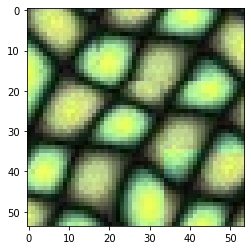

In [403]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('todo.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print(img.shape)
finalImage,overlapPlot = quilt(img, 20 , (3, 3), "cut")
plt.imshow(finalImage)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


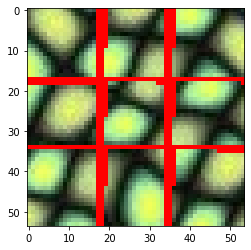

In [394]:
plt.imshow(overlapPlot)

(157, 237, 3)
(157, 237, 3)
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177
177 177


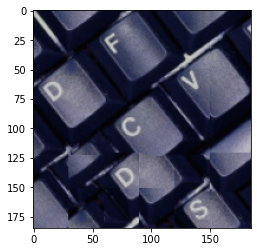

In [409]:
import cv2
import matplotlib.pyplot as plt
keyimg = cv2.imread('key.png')
keyimg = cv2.cvtColor(keyimg, cv2.COLOR_BGR2RGB)
plt.imshow(keyimg)
print(keyimg.shape)
keyimg,overlapImage = quilt(keyimg, 50, (6,6), "cut")
plt.imshow(keyimg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


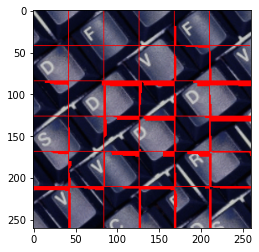

In [405]:
plt.imshow(overlapImage)